In [13]:
# ------------------------------------------------ #
#                  IMPORT FUNCTIONS                #
# ------------------------------------------------ #
import os
import sys
import datetime

# Get the project root directory (going up one level from Notebooks)
project_root = os.path.dirname(os.getcwd())
# Add the Scripts directory to Python path so we can import modules from individual scripts files
scripts_dir = os.path.join(project_root, 'Scripts')
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

# Add functions here from Scripts folder
from ao_indices import return_AO_fetch
from enso_indices import return_ENSO_fetch
from breakup_data import calculate_breakup_data
from breakup_data import calculate_estimated_breakup
from bounding_box import calculate_bounding_box
from raster_temp import mean_30d_raster_temps
from raster_temp import monthly_raster_temps
#from raster_temp_era5 import mean_30d_raster_temps
from correlation_function import calculate_ao_correlation_per_month, calculate_enso_correlation_per_month, plot_heatmap
from correlation_raster import calculate_ao_correlation, calculate_enso_correlation, save_results_to_csv, plot_results

In [14]:
# ------------------------------------------------ #
#                CLASS DEFINITION                  #
# ------------------------------------------------ #

class StudySite:
    def __init__(self,name):
        self.name = name
        self.breakup_anomaly_data = None # Dictionary of integer years (e.g. 2000) with following data subkeys: zscore_index, anomaly_days, breakup_date, breakup_doy
        self.estimated_breakup_doy = None # The MEAN breakup date for the study site across all years, in DOY integer format.
        self.enso_indices = None # Dictionary of integer years (e.g. 2000) with enso_value for each of 12 months before breakup, named as strings
        self.ao_indices = None # Dictionary of integer years (e.g. 2000) with ao_value for each of 12 months before breakup
        self.bounding_box = None  # Dictionary of max_lat:value, min_lat:value, max_lon:value, min_lon:value
        self.mean_30d_raster_temps = None # Dictionary of integer years (e.g. 2000) with rasters of the mean breakup temperature across the 30 days prior to mean breakup date (we can't do actual breakup date because months have different temps)
        self.monthly_raster_temps = None
        self.enso_correlations = None # Single raster of ENSO correlations across all years
        self.ao_correlations = None # Single raster of AO correlations across all years


    def calculate_breakup_data(self, ice_data_filepath, years_of_data):
        """ Load ice breakup data for this site from the provided icedata spreadsheet, filtering by years_of_data and the site name """

        # Dictionary of integer years (e.g. 2000) with following data subkeys: zscore_index, anomaly_days, breakup_doy
        self.breakup_anomaly_data = calculate_breakup_data(years_of_data, ice_data_filepath, self.name)

        # Single value of estimated breakup day of year for this site (MEAN across all years)
        self.estimated_breakup_doy = calculate_estimated_breakup(self.breakup_anomaly_data)


    def fetch_enso(self,enso_data_filepath):
        """ Pull in ENSO data as dictionary of integer years (e.g. 2000) on a MONTHLY scale for 12 months prior to estimated breakup 
            date from all years of data (excluding month with breakup date, as we are looking for time lag of 1+ months) """
        
        # Dictionary of integer years (e.g. 2000) with dictionary of preceding 12 month_name: month_values
        self.enso_indices = return_ENSO_fetch(enso_data_filepath, self.breakup_anomaly_data, self.estimated_breakup_doy)


    def fetch_ao(self,ao_data_filepath):
        """ Pull in AO data as dictionary of integer years (e.g. 2000) on a MONTHLY scale for 12 months prior to estimated breakup 
            date from all years of data (excluding month with breakup date, as we are looking for time lag of 1+ months) """
        
        # Dictionary of integer years (e.g. 2000) with dictionary of preceding 12 month_name: month_values
        self.ao_indices = return_AO_fetch(ao_data_filepath, self.breakup_anomaly_data, self.estimated_breakup_doy)


    def calculate_bounding_box(self, ice_data_filepath):
        """ Calculate 100km bounding box based on study site coordinates """

        # Bounding box for this site based on lat,lon for each site in the ice data CSV
        # Dictionary of max_lat:value, min_lat:value, max_lon:value, min_lon:value
        self.bounding_box = calculate_bounding_box(ice_data_filepath, self.name)


    def calculate_mean_30d_raster_temps(self):
        """ Pull the raster data within the bounding box for each of the 30d prior to the given breakup date variable, then average all the rasters together to return the mean 30d temp for each year."""

        # Dictionary of integer years (e.g. 2000) paired with rasters of the mean breakup temperature across the 30 days prior to given breakup date variable for each year
        # (Note we can't do actual breakup date for each year for each site due to statistical reasons, so for each site we will find the mean breakup date and use that to find our 30d period)
        self.mean_30d_raster_temps = mean_30d_raster_temps(self.bounding_box, self.breakup_anomaly_data, self.estimated_breakup_doy)
       
    def calculate_monthly_raster_temps(self):
        self.monthly_raster_temps_data = monthly_raster_temps(self.bounding_box, self.breakup_anomaly_data, self.estimated_breakup_doy)
        return self.monthly_raster_temps_data
    
    # For each month in our indices in the 12 months prior to breakup (excluding breakup month,) calculate the P value across all years of data
    # Single raster for each of these consisting of correlation across all years
    def calculate_ao_correlation(self, ice_data_filepath, ao_data_filepath, project_root, lag=1):
        """Calculate AO correlations for this study site."""
        self.ao_correlations = calculate_ao_correlation(
            site_name=self.name,
            ice_data_filepath=ice_data_filepath,
            ao_data_filepath=ao_data_filepath,
            project_root=project_root,
            lag=lag
        )

    def calculate_enso_correlation(self, ice_data_filepath, enso_data_filepath, project_root, lag=1):
        """Calculate ENSO correlations for this study site."""
        self.enso_correlations = calculate_enso_correlation(
            site_name=self.name,
            ice_data_filepath=ice_data_filepath,
            enso_data_filepath=enso_data_filepath,
            project_root=project_root,
            lag=lag
        )

In [15]:
# ------------------------------------------------ #
#                  PARAMETERS                      #
# ------------------------------------------------ #

# Add data here from Data folder
enso_data_filepath = os.path.join(project_root, "Data", "ENSO_index.txt")
ao_data_filepath = os.path.join(project_root, "Data", "AO_index.txt")
ice_data_filepath = os.path.join(project_root, "Data", "ice_data.csv")
results_dir = os.path.join(project_root, "Results")
os.makedirs(results_dir, exist_ok=True)

# Choose study sites here "Gambell","Teller","Nuiqsut","Shishmaref","Savoonga","Prudhoe Bay","Kaktovik" miss some data
study_site_names = ["Nunam Iqua","Stebbins","Hooper Bay","Mekoryuk","Utqiagvik","Kotzebue","Elim","Toksook Bay","Shaktoolik","Kwigillingok","Scammon Bay","Nome","Point Hope","Chefornak","Tununak","Kotlik","Newtok","Brevig Mission","Wainwright","Koyuk","Alakanuk","Quinhagak","Kivalina","Emmonak","Golovin","Kipnuk","Unalakleet","Point Lay","Deering","Wales","Kongiganak"]

# Generate a list of years from 2000 to 2022 - select years
years_of_data = list(range(2000, 2023))

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# ------------------------------------------------ #
#                  MAIN CODE                       #
# ------------------------------------------------ #

# Create list of StudySite objects
sites = [StudySite(name) for name in study_site_names]

# Process data for each site
for site in sites:
    # Calculate basic site data
    site.calculate_breakup_data(ice_data_filepath, years_of_data)
    site.fetch_enso(enso_data_filepath)
    site.fetch_ao(ao_data_filepath)
    site.calculate_bounding_box(ice_data_filepath)
    site.calculate_mean_30d_raster_temps()
    site.calculate_monthly_raster_temps()
    
    # Calculate AO correlations per year
    ao_correlation_results = []
    for year in years_of_data:
        if year not in site.ao_indices or year not in site.monthly_raster_temps_data:
            continue

        avg_temps = []
        ao_values = []
        for month_data in site.monthly_raster_temps_data[year]:
            avg_temp = np.ma.mean(month_data["month_value"])
            if not np.isnan(avg_temp):  # Skip invalid values
                avg_temps.append(avg_temp)

        for month_data in site.ao_indices[year]:
            ao_values.append(month_data["month_value"])

        if len(avg_temps) == len(ao_values) and len(avg_temps) > 1:
            correlation, p_value = pearsonr(avg_temps, ao_values)
            ao_correlation_results.append({"Year": year, "Correlation": correlation, "P-Value": p_value})
        else:
            print(f"Skipping year {year} for {site.name} due to insufficient or mismatched data.")

    # Save AO correlations to CSV
    if ao_correlation_results:
        ao_correlation_df = pd.DataFrame(ao_correlation_results)
        ao_csv_path = os.path.join(results_dir, f"ao_correlation_{site.name}.csv")
        ao_correlation_df.to_csv(ao_csv_path, index=False)
        print(f"AO correlations saved for {site.name} at {ao_csv_path}")

        # Plot AO correlations
        plt.figure(figsize=(10, 6))
        plt.plot(ao_correlation_df["Year"], ao_correlation_df["Correlation"], marker="o", color="blue", label="AO Correlation")
        plt.title(f"AO Correlation: {site.name}")
        plt.xlabel("Year")
        plt.ylabel("Correlation Coefficient")
        plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Reference line at 0
        plt.legend()
        plt.grid(True)

        ao_plot_path = os.path.join(results_dir, "AO_Plots", f"{site.name}_AO_correlation.png")
        os.makedirs(os.path.dirname(ao_plot_path), exist_ok=True)
        plt.savefig(ao_plot_path)
        plt.close()
        print(f"AO correlation plot saved for {site.name} at {ao_plot_path}")
    
    # Calculate ENSO correlations per year
    enso_correlation_results = []
    for year in years_of_data:
        if year not in site.enso_indices or year not in site.monthly_raster_temps_data:
            continue

        avg_temps = []
        enso_values = []
        for month_data in site.monthly_raster_temps_data[year]:
            avg_temp = np.ma.mean(month_data["month_value"])
            if not np.isnan(avg_temp):  # Skip invalid values
                avg_temps.append(avg_temp)

        for month_data in site.enso_indices[year]:
            enso_values.append(month_data["month_value"])

        if len(avg_temps) == len(enso_values) and len(avg_temps) > 1:
            correlation, p_value = pearsonr(avg_temps, enso_values)
            enso_correlation_results.append({"Year": year, "Correlation": correlation, "P-Value": p_value})
        else:
            print(f"Skipping year {year} for {site.name} due to insufficient or mismatched data.")

    # Save ENSO correlations to CSV
    if enso_correlation_results:
        enso_correlation_df = pd.DataFrame(enso_correlation_results)
        enso_csv_path = os.path.join(results_dir, f"enso_correlation_{site.name}.csv")
        enso_correlation_df.to_csv(enso_csv_path, index=False)
        print(f"ENSO correlations saved for {site.name} at {enso_csv_path}")

        # Plot ENSO correlations
        plt.figure(figsize=(10, 6))
        plt.plot(enso_correlation_df["Year"], enso_correlation_df["Correlation"], marker="o", color="green", label="ENSO Correlation")
        plt.title(f"ENSO Correlation: {site.name}")
        plt.xlabel("Year")
        plt.ylabel("Correlation Coefficient")
        plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)  # Reference line at 0
        plt.legend()
        plt.grid(True)

        enso_plot_path = os.path.join(results_dir, "ENSO_Plots", f"{site.name}_ENSO_correlation.png")
        os.makedirs(os.path.dirname(enso_plot_path), exist_ok=True)
        plt.savefig(enso_plot_path)
        plt.close()
        print(f"ENSO correlation plot saved for {site.name} at {enso_plot_path}")


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Nunam Iqua at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Nunam Iqua.csv
AO correlation plot saved for Nunam Iqua at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Nunam Iqua_AO_correlation.png
ENSO correlations saved for Nunam Iqua at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Nunam Iqua.csv
ENSO correlation plot saved for Nunam Iqua at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Nunam Iqua_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Stebbins at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Stebbins.csv
AO correlation plot saved for Stebbins at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Stebbins_AO_correlation.png
ENSO correlations saved for Stebbins at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Stebbins.csv
ENSO correlation plot saved for Stebbins at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Stebbins_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Hooper Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Hooper Bay.csv
AO correlation plot saved for Hooper Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Hooper Bay_AO_correlation.png
ENSO correlations saved for Hooper Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Hooper Bay.csv
ENSO correlation plot saved for Hooper Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Hooper Bay_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Mekoryuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Mekoryuk.csv
AO correlation plot saved for Mekoryuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Mekoryuk_AO_correlation.png
ENSO correlations saved for Mekoryuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Mekoryuk.csv
ENSO correlation plot saved for Mekoryuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Mekoryuk_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Utqiagvik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Utqiagvik.csv
AO correlation plot saved for Utqiagvik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Utqiagvik_AO_correlation.png
ENSO correlations saved for Utqiagvik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Utqiagvik.csv
ENSO correlation plot saved for Utqiagvik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Utqiagvik_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Kotzebue at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Kotzebue.csv
AO correlation plot saved for Kotzebue at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Kotzebue_AO_correlation.png
ENSO correlations saved for Kotzebue at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Kotzebue.csv
ENSO correlation plot saved for Kotzebue at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Kotzebue_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Elim at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Elim.csv
AO correlation plot saved for Elim at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Elim_AO_correlation.png
ENSO correlations saved for Elim at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Elim.csv
ENSO correlation plot saved for Elim at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Elim_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Toksook Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Toksook Bay.csv
AO correlation plot saved for Toksook Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Toksook Bay_AO_correlation.png
ENSO correlations saved for Toksook Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Toksook Bay.csv
ENSO correlation plot saved for Toksook Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Toksook Bay_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Shaktoolik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Shaktoolik.csv
AO correlation plot saved for Shaktoolik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Shaktoolik_AO_correlation.png
ENSO correlations saved for Shaktoolik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Shaktoolik.csv
ENSO correlation plot saved for Shaktoolik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Shaktoolik_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Kwigillingok at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Kwigillingok.csv
AO correlation plot saved for Kwigillingok at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Kwigillingok_AO_correlation.png
ENSO correlations saved for Kwigillingok at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Kwigillingok.csv
ENSO correlation plot saved for Kwigillingok at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Kwigillingok_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Scammon Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Scammon Bay.csv
AO correlation plot saved for Scammon Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Scammon Bay_AO_correlation.png
ENSO correlations saved for Scammon Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Scammon Bay.csv
ENSO correlation plot saved for Scammon Bay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Scammon Bay_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Nome at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Nome.csv
AO correlation plot saved for Nome at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Nome_AO_correlation.png
ENSO correlations saved for Nome at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Nome.csv
ENSO correlation plot saved for Nome at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Nome_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Point Hope at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Point Hope.csv
AO correlation plot saved for Point Hope at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Point Hope_AO_correlation.png
ENSO correlations saved for Point Hope at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Point Hope.csv
ENSO correlation plot saved for Point Hope at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Point Hope_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Chefornak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Chefornak.csv
AO correlation plot saved for Chefornak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Chefornak_AO_correlation.png
ENSO correlations saved for Chefornak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Chefornak.csv
ENSO correlation plot saved for Chefornak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Chefornak_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Tununak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Tununak.csv
AO correlation plot saved for Tununak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Tununak_AO_correlation.png
ENSO correlations saved for Tununak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Tununak.csv
ENSO correlation plot saved for Tununak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Tununak_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Kotlik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Kotlik.csv
AO correlation plot saved for Kotlik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Kotlik_AO_correlation.png
ENSO correlations saved for Kotlik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Kotlik.csv
ENSO correlation plot saved for Kotlik at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Kotlik_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Newtok at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Newtok.csv
AO correlation plot saved for Newtok at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Newtok_AO_correlation.png
ENSO correlations saved for Newtok at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Newtok.csv
ENSO correlation plot saved for Newtok at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Newtok_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Brevig Mission at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Brevig Mission.csv
AO correlation plot saved for Brevig Mission at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Brevig Mission_AO_correlation.png
ENSO correlations saved for Brevig Mission at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Brevig Mission.csv
ENSO correlation plot saved for Brevig Mission at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Brevig Mission_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Wainwright at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Wainwright.csv
AO correlation plot saved for Wainwright at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Wainwright_AO_correlation.png
ENSO correlations saved for Wainwright at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Wainwright.csv
ENSO correlation plot saved for Wainwright at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Wainwright_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Koyuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Koyuk.csv
AO correlation plot saved for Koyuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Koyuk_AO_correlation.png
ENSO correlations saved for Koyuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Koyuk.csv
ENSO correlation plot saved for Koyuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Koyuk_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Alakanuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Alakanuk.csv
AO correlation plot saved for Alakanuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Alakanuk_AO_correlation.png
ENSO correlations saved for Alakanuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Alakanuk.csv
ENSO correlation plot saved for Alakanuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Alakanuk_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Quinhagak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Quinhagak.csv
AO correlation plot saved for Quinhagak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Quinhagak_AO_correlation.png
ENSO correlations saved for Quinhagak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Quinhagak.csv
ENSO correlation plot saved for Quinhagak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Quinhagak_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Kivalina at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Kivalina.csv
AO correlation plot saved for Kivalina at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Kivalina_AO_correlation.png
ENSO correlations saved for Kivalina at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Kivalina.csv
ENSO correlation plot saved for Kivalina at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Kivalina_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Emmonak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Emmonak.csv
AO correlation plot saved for Emmonak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Emmonak_AO_correlation.png
ENSO correlations saved for Emmonak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Emmonak.csv
ENSO correlation plot saved for Emmonak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Emmonak_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Golovin at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Golovin.csv
AO correlation plot saved for Golovin at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Golovin_AO_correlation.png
ENSO correlations saved for Golovin at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Golovin.csv
ENSO correlation plot saved for Golovin at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Golovin_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Kipnuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Kipnuk.csv
AO correlation plot saved for Kipnuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Kipnuk_AO_correlation.png
ENSO correlations saved for Kipnuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Kipnuk.csv
ENSO correlation plot saved for Kipnuk at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Kipnuk_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Unalakleet at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Unalakleet.csv
AO correlation plot saved for Unalakleet at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Unalakleet_AO_correlation.png
ENSO correlations saved for Unalakleet at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Unalakleet.csv
ENSO correlation plot saved for Unalakleet at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Unalakleet_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Point Lay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Point Lay.csv
AO correlation plot saved for Point Lay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Point Lay_AO_correlation.png
ENSO correlations saved for Point Lay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Point Lay.csv
ENSO correlation plot saved for Point Lay at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Point Lay_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Deering at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Deering.csv
AO correlation plot saved for Deering at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Deering_AO_correlation.png
ENSO correlations saved for Deering at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Deering.csv
ENSO correlation plot saved for Deering at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Deering_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Wales at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Wales.csv
AO correlation plot saved for Wales at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Wales_AO_correlation.png
ENSO correlations saved for Wales at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Wales.csv
ENSO correlation plot saved for Wales at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Wales_ENSO_correlation.png


/Users/anastringer_1/attempt_2_cee/cee506_class_project/Scripts/ao_indices.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(ao_data_filepath, delim_whitespace=True, index_col=0)


AO correlations saved for Kongiganak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ao_correlation_Kongiganak.csv
AO correlation plot saved for Kongiganak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/AO_Plots/Kongiganak_AO_correlation.png
ENSO correlations saved for Kongiganak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/enso_correlation_Kongiganak.csv
ENSO correlation plot saved for Kongiganak at /Users/anastringer_1/attempt_2_cee/cee506_class_project/Results/ENSO_Plots/Kongiganak_ENSO_correlation.png


In [17]:
# ------------------------------------------------ #
#       CORRELATION AND PLOTTING (Optional)        #
# ------------------------------------------------ #

# Save and plot AO and ENSO correlations for each site
for site in sites:
    if site.ao_correlations is not None:
        # Save AO correlations to CSV
        ao_csv_path = os.path.join(results_dir, f"ao_correlation_{site.name}.csv")
        save_results_to_csv(site.ao_correlations, ao_csv_path)
        
        # Plot AO correlations
        ao_plot_dir = os.path.join(results_dir, "AO_Plots")
        plot_results(site.ao_correlations, "AO", ao_plot_dir)
    
    if site.enso_correlations is not None:
        # Save ENSO correlations to CSV
        enso_csv_path = os.path.join(results_dir, f"enso_correlation_{site.name}.csv")
        save_results_to_csv(site.enso_correlations, enso_csv_path)
        
        # Plot ENSO correlations
        enso_plot_dir = os.path.join(results_dir, "ENSO_Plots")
        plot_results(site.enso_correlations, "ENSO", enso_plot_dir)

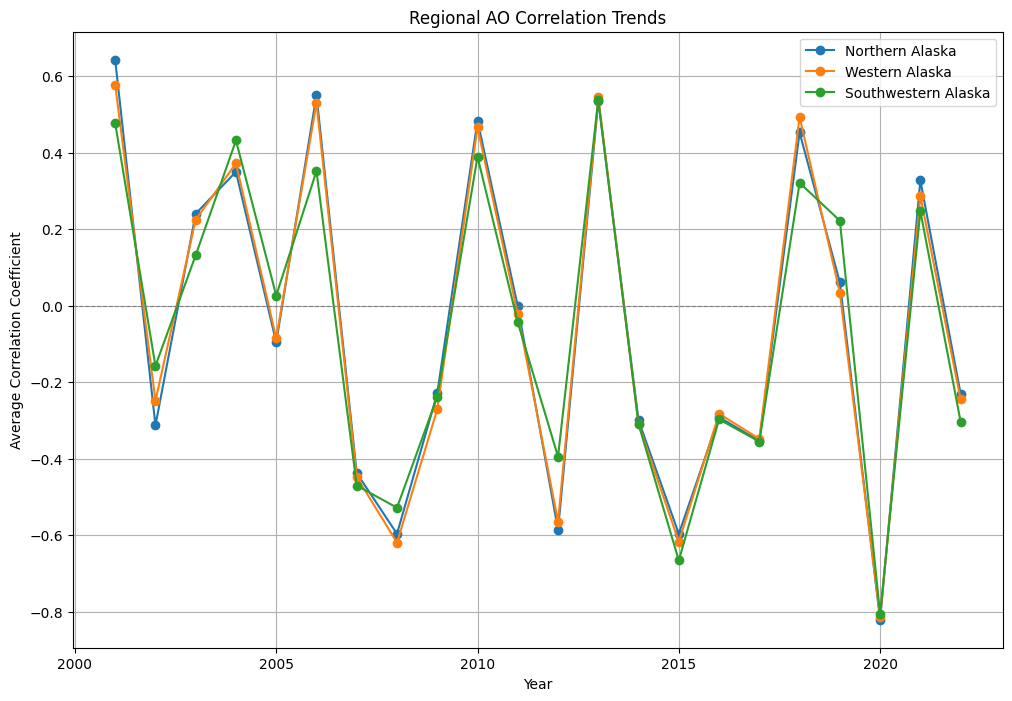

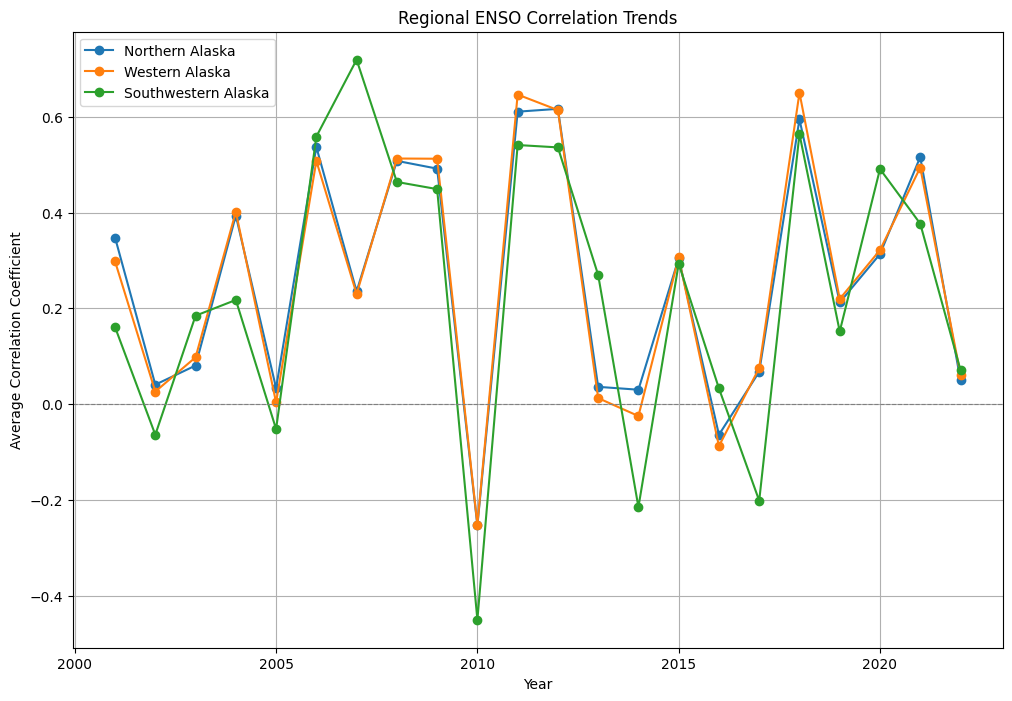

Statistical Comparison for AO Correlations:
Northern Alaska vs. Western Alaska: t=0.05, p=0.962
Northern Alaska vs. Southwestern Alaska: t=0.08, p=0.936
Western Alaska vs. Southwestern Alaska: t=0.03, p=0.975
Statistical Comparison for ENSO Correlations:
Northern Alaska vs. Western Alaska: t=0.04, p=0.965
Northern Alaska vs. Southwestern Alaska: t=0.33, p=0.746
Western Alaska vs. Southwestern Alaska: t=0.28, p=0.780


In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# ------------------------------------------------ #
#       Load AO and ENSO Correlation Data          #
# ------------------------------------------------ #

# Define community groups
group_1 = ["Nuiqsut", "Prudhoe Bay", "Utqiaġvik", "Wainwright", "Kaktovik"]
group_2 = ["Point Lay", "Point Hope", "Kotzebue", "Shishmaref"]
group_3 = ["Scammon Bay", "Hooper Bay", "Toksook Bay", "Kipnuk"]

region_groups = {
    "Northern Alaska": group_1,
    "Western Alaska": group_2,
    "Southwestern Alaska": group_3
}

# Initialize regional data storage
ao_regional_data = {region: [] for region in region_groups}
enso_regional_data = {region: [] for region in region_groups}

# Load AO and ENSO correlations from `results_dir`
for region, communities in region_groups.items():
    for community in communities:
        # Load AO correlations
        ao_csv_path = os.path.join(results_dir, f"ao_correlation_{community}.csv")
        if os.path.exists(ao_csv_path):
            ao_df = pd.read_csv(ao_csv_path)
            ao_regional_data[region].append(ao_df)

        # Load ENSO correlations
        enso_csv_path = os.path.join(results_dir, f"enso_correlation_{community}.csv")
        if os.path.exists(enso_csv_path):
            enso_df = pd.read_csv(enso_csv_path)
            enso_regional_data[region].append(enso_df)

# ------------------------------------------------ #
#       Calculate Regional Averages and Trends     #
# ------------------------------------------------ #

regional_trends = {"AO": {}, "ENSO": {}}
for region, ao_data in ao_regional_data.items():
    if ao_data:
        combined_ao_df = pd.concat(ao_data, ignore_index=True)
        regional_ao_avg = combined_ao_df.groupby("Year")["Correlation"].mean()
        regional_trends["AO"][region] = regional_ao_avg

for region, enso_data in enso_regional_data.items():
    if enso_data:
        combined_enso_df = pd.concat(enso_data, ignore_index=True)
        regional_enso_avg = combined_enso_df.groupby("Year")["Correlation"].mean()
        regional_trends["ENSO"][region] = regional_enso_avg

# ------------------------------------------------ #
#       PLOT REGIONAL TRENDS                       #
# ------------------------------------------------ #

for variable in ["AO", "ENSO"]:
    plt.figure(figsize=(12, 8))
    for region, trend in regional_trends[variable].items():
        plt.plot(trend.index, trend.values, marker="o", label=region)
    plt.title(f"Regional {variable} Correlation Trends")
    plt.xlabel("Year")
    plt.ylabel("Average Correlation Coefficient")
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------------------------------ #
#       STATISTICAL ANALYSIS BETWEEN REGIONS       #
# ------------------------------------------------ #

for variable, data in regional_trends.items():
    print(f"Statistical Comparison for {variable} Correlations:")
    region_keys = list(data.keys())
    for i in range(len(region_keys)):
        for j in range(i + 1, len(region_keys)):
            group_1 = data[region_keys[i]].dropna()
            group_2 = data[region_keys[j]].dropna()
            t_stat, p_value = ttest_ind(group_1, group_2, equal_var=False)  # Welch's t-test
            print(f"{region_keys[i]} vs. {region_keys[j]}: t={t_stat:.2f}, p={p_value:.3f}")


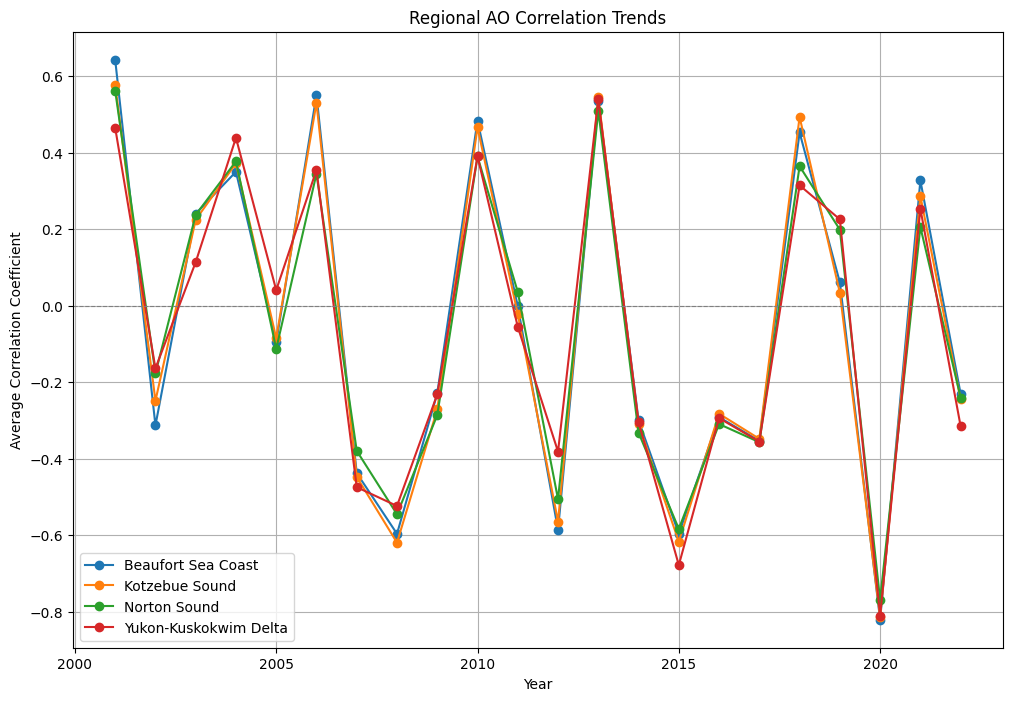

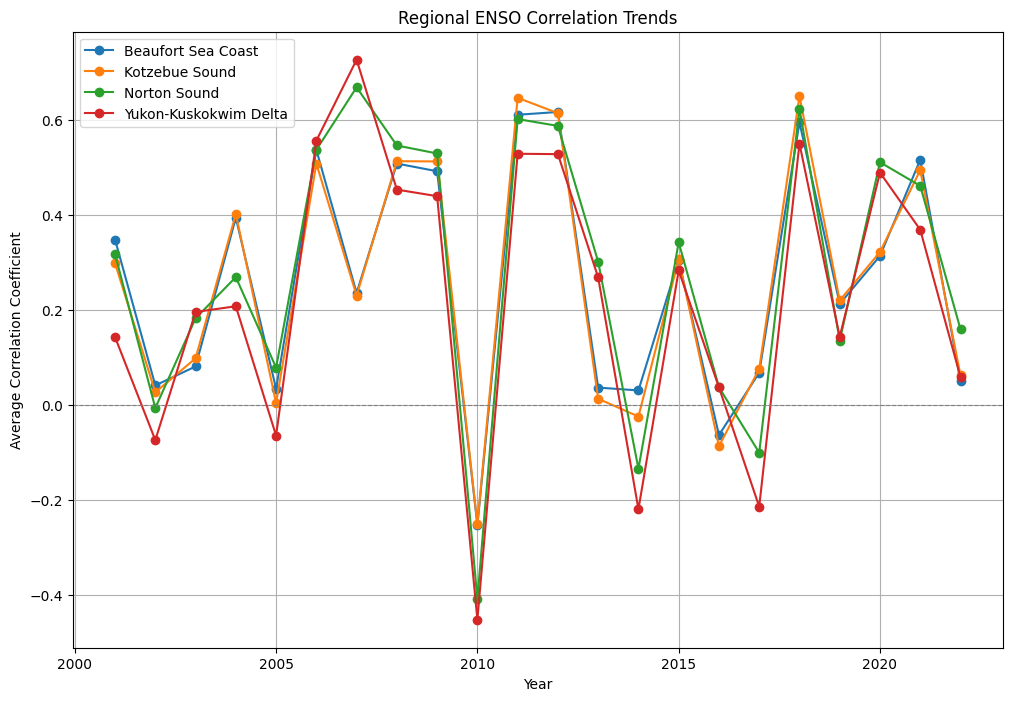

Statistical Comparison for AO Correlations:
Beaufort Sea Coast vs. Kotzebue Sound: t=0.05, p=0.962
Beaufort Sea Coast vs. Norton Sound: t=0.06, p=0.954
Beaufort Sea Coast vs. Yukon-Kuskokwim Delta: t=0.09, p=0.931
Kotzebue Sound vs. Norton Sound: t=0.01, p=0.993
Kotzebue Sound vs. Yukon-Kuskokwim Delta: t=0.04, p=0.970
Norton Sound vs. Yukon-Kuskokwim Delta: t=0.03, p=0.976
Statistical Comparison for ENSO Correlations:
Beaufort Sea Coast vs. Kotzebue Sound: t=0.04, p=0.965
Beaufort Sea Coast vs. Norton Sound: t=-0.29, p=0.771
Beaufort Sea Coast vs. Yukon-Kuskokwim Delta: t=0.41, p=0.685
Kotzebue Sound vs. Norton Sound: t=-0.33, p=0.744
Kotzebue Sound vs. Yukon-Kuskokwim Delta: t=0.36, p=0.719
Norton Sound vs. Yukon-Kuskokwim Delta: t=0.65, p=0.518


In [27]:
# ------------------------------------------------ #
#       Regional Group Analysis                    #
# ------------------------------------------------ #

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Define community groups based on updated groupings
region_groups = {
    "Beaufort Sea Coast": ["Utqiaġvik", "Nuiqsut", "Prudhoe Bay", "Wainwright", "Kaktovik"],
    "Kotzebue Sound": ["Kotzebue", "Point Lay", "Point Hope"],
    "Norton Sound": ["Nome", "Golovin", "Elim", "Unalakleet", "Shaktoolik", "Stebbins"],
    "Yukon-Kuskokwim Delta": ["Scammon Bay", "Hooper Bay", "Toksook Bay", "Kipnuk", "Mekoryuk"]
}

# Initialize regional data storage
ao_regional_data = {region: [] for region in region_groups}
enso_regional_data = {region: [] for region in region_groups}

# Load AO and ENSO correlations from `results_dir`
for region, communities in region_groups.items():
    for community in communities:
        # Load AO correlations
        ao_csv_path = os.path.join(results_dir, f"ao_correlation_{community}.csv")
        if os.path.exists(ao_csv_path):
            ao_df = pd.read_csv(ao_csv_path)
            ao_regional_data[region].append(ao_df)

        # Load ENSO correlations
        enso_csv_path = os.path.join(results_dir, f"enso_correlation_{community}.csv")
        if os.path.exists(enso_csv_path):
            enso_df = pd.read_csv(enso_csv_path)
            enso_regional_data[region].append(enso_df)

# Calculate regional averages and trends
regional_trends = {"AO": {}, "ENSO": {}}
for region, ao_data in ao_regional_data.items():
    if ao_data:
        combined_ao_df = pd.concat(ao_data, ignore_index=True)
        regional_ao_avg = combined_ao_df.groupby("Year")["Correlation"].mean()
        regional_trends["AO"][region] = regional_ao_avg

for region, enso_data in enso_regional_data.items():
    if enso_data:
        combined_enso_df = pd.concat(enso_data, ignore_index=True)
        regional_enso_avg = combined_enso_df.groupby("Year")["Correlation"].mean()
        regional_trends["ENSO"][region] = regional_enso_avg

# Plot regional trends
for variable in ["AO", "ENSO"]:
    plt.figure(figsize=(12, 8))
    for region, trend in regional_trends[variable].items():
        plt.plot(trend.index, trend.values, marker="o", label=region)
    plt.title(f"Regional {variable} Correlation Trends")
    plt.xlabel("Year")
    plt.ylabel("Average Correlation Coefficient")
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.legend()
    plt.grid(True)
    plt.show()

# Perform statistical analysis between regions
for variable, data in regional_trends.items():
    print(f"Statistical Comparison for {variable} Correlations:")
    region_keys = list(data.keys())
    for i in range(len(region_keys)):
        for j in range(i + 1, len(region_keys)):
            group_1 = data[region_keys[i]].dropna()
            group_2 = data[region_keys[j]].dropna()
            t_stat, p_value = ttest_ind(group_1, group_2, equal_var=False)  # Welch's t-test
            print(f"{region_keys[i]} vs. {region_keys[j]}: t={t_stat:.2f}, p={p_value:.3f}")


NameError: name 'years' is not defined

Processing site: Nunam Iqua
Data prepared for Nunam Iqua:
   Year  Month  AO Index                                        30-Day Temp  \
0  2001  March    -1.687  [[-4.936261, -4.6115212, -4.291469, -3.9779277...   
1  2001  April     0.906  [[-4.936261, -4.6115212, -4.291469, -3.9779277...   
2  2001    May     0.969  [[-4.936261, -4.6115212, -4.291469, -3.9779277...   
3  2002  March     0.902  [[1.6940958, 1.8651897, 2.1013875, 2.425346, 2...   
4  2002  April     0.748  [[1.6940958, 1.8651897, 2.1013875, 2.425346, 2...   

   Cumulative AO  
0       0.062667  
1       0.062667  
2       0.062667  
3       0.700667  
4       0.700667  


ValueError: setting an array element with a sequence.

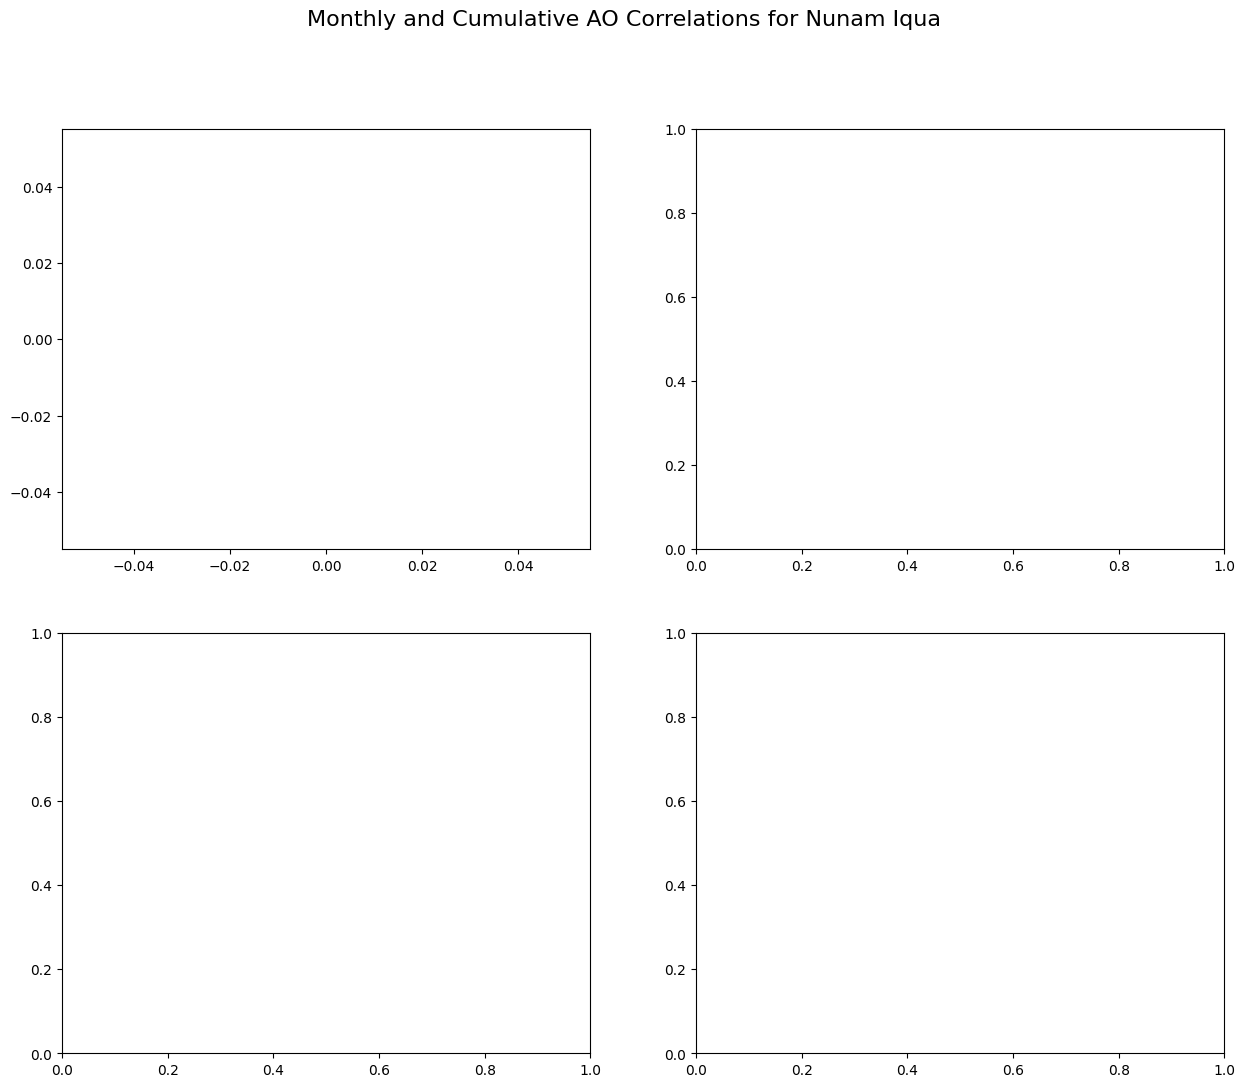

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def debug_and_plot_correlations(site):
    """
    Debug and plot monthly and cumulative AO correlations for a given community.

    Parameters:
    - site (object): Site object containing name, 30-day raster values, and AO indices.
    """
    # Extract site name and data
    site_name = site.name
    mean_30d_raster_values = site.mean_30d_raster_temps
    ao_indices = site.ao_indices

    # Debugging: Log site information
    print(f"Processing site: {site_name}")
    if not mean_30d_raster_values:
        print("No 30-day raster values found.")
        return
    if not ao_indices:
        print("No AO indices found.")
        return

    # Prepare data for plotting
    correlation_data = []

    for year in mean_30d_raster_values.keys():
        if year in ao_indices and year in mean_30d_raster_values:
            # Extract AO indices for March, April, May
            spring_indices = {
                "March": next((entry["month_value"] for entry in ao_indices[year] if entry["month_name"] == "March"), None),
                "April": next((entry["month_value"] for entry in ao_indices[year] if entry["month_name"] == "April"), None),
                "May": next((entry["month_value"] for entry in ao_indices[year] if entry["month_name"] == "May"), None)
            }

            # Calculate cumulative AO (March-May)
            valid_indices = {month: value for month, value in spring_indices.items() if value is not None}
            cumulative_ao = sum(valid_indices.values()) / len(valid_indices.values()) if valid_indices else None

            # Extract 30-day raster temperature
            temp_30d = mean_30d_raster_values[year]

            # Append to correlation data
            for month, ao_value in valid_indices.items():
                correlation_data.append({
                    "Year": year,
                    "Month": month,
                    "AO Index": ao_value,
                    "30-Day Temp": temp_30d,
                    "Cumulative AO": cumulative_ao
                })

    # Convert to DataFrame
    if not correlation_data:
        print(f"No valid data for site {site_name}. Exiting.")
        return

    df = pd.DataFrame(correlation_data)
    print(f"Data prepared for {site_name}:")
    print(df.head())

    # Plot data
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f"Monthly and Cumulative AO Correlations for {site_name}", fontsize=16)

    # Plot each month
    for ax, month in zip(axes.flatten()[:3], ["March", "April", "May"]):
        month_data = df[df["Month"] == month]
        if month_data.empty:
            print(f"No data for {month}. Skipping plot.")
            continue
        sns.regplot(
            x="AO Index", y="30-Day Temp", data=month_data, ax=ax,
            scatter_kws={"color": "blue", "s": 50}, line_kws={"color": "red", "alpha": 0.7}
        )
        ax.set_title(f"{month} AO vs. 30-Day Temp")
        ax.set_xlabel(f"{month} AO Index")
        ax.set_ylabel("30-Day Temp (°C)")

    # Plot cumulative AO
    cumulative_data = df.drop_duplicates(subset=["Year"])
    if not cumulative_data.empty:
        sns.regplot(
            x="Cumulative AO", y="30-Day Temp", data=cumulative_data, ax=axes[1, 1],
            scatter_kws={"color": "green", "s": 50}, line_kws={"color": "green", "alpha": 0.7}
        )
        axes[1, 1].set_title("Cumulative AO (Mar-May) vs. 30-Day Temp")
        axes[1, 1].set_xlabel("Cumulative AO Index")
        axes[1, 1].set_ylabel("30-Day Temp (°C)")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage: Replace 'sites[0]' with the actual site object you want to test
debug_and_plot_correlations(site=sites[0])


Processing site: Nunam Iqua
Data prepared for Nunam Iqua:
   Year  Month  AO Index  30-Day Temp  Cumulative AO
0  2001  March    -1.687    -3.341457       0.062667
1  2001  April     0.906    -3.341457       0.062667
2  2001    May     0.969    -3.341457       0.062667
3  2002  March     0.902     3.066802       0.700667
4  2002  April     0.748     3.066802       0.700667


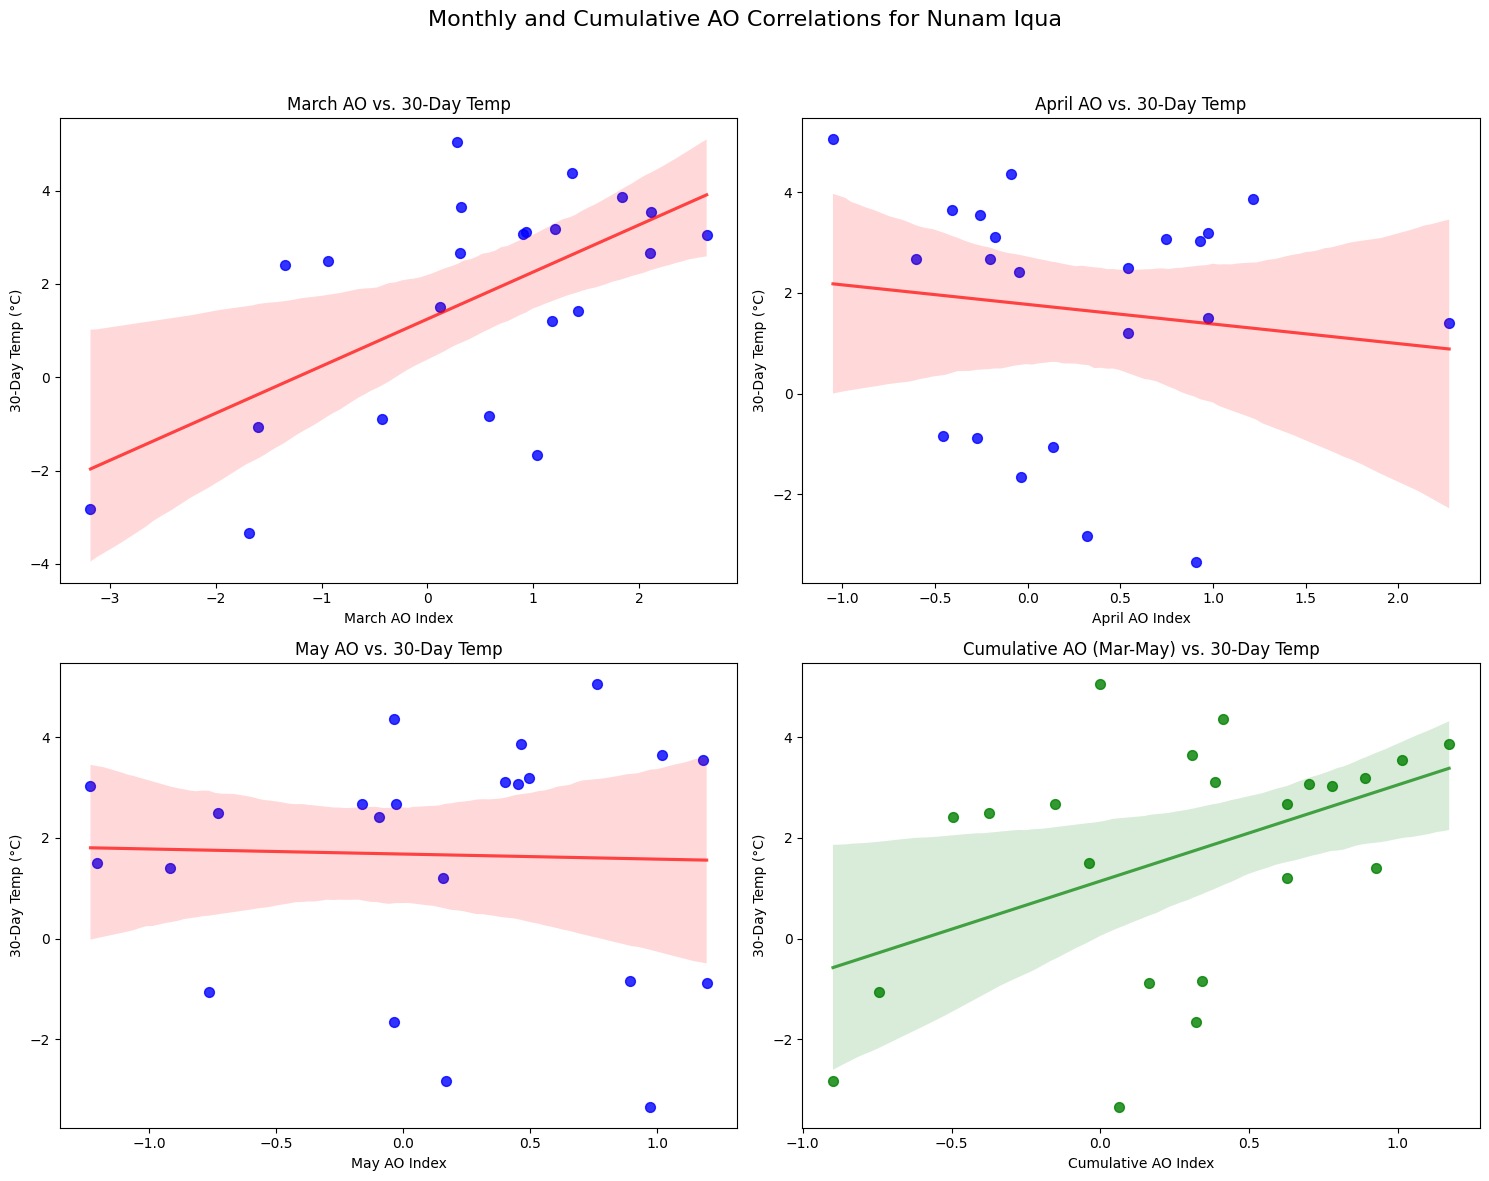

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def debug_and_plot_correlations(site):
    """
    Debug and plot monthly and cumulative AO correlations for a given community.

    Parameters:
    - site (object): Site object containing name, 30-day raster values, and AO indices.
    """
    # Extract site name and data
    site_name = site.name
    mean_30d_raster_values = site.mean_30d_raster_temps
    ao_indices = site.ao_indices

    # Debugging: Log site information
    print(f"Processing site: {site_name}")
    if not mean_30d_raster_values:
        print("No 30-day raster values found.")
        return
    if not ao_indices:
        print("No AO indices found.")
        return

    # Prepare data for plotting
    correlation_data = []

    for year in mean_30d_raster_values.keys():
        if year in ao_indices and year in mean_30d_raster_values:
            # Extract AO indices for March, April, May
            spring_indices = {
                "March": next((entry["month_value"] for entry in ao_indices[year] if entry["month_name"] == "March"), None),
                "April": next((entry["month_value"] for entry in ao_indices[year] if entry["month_name"] == "April"), None),
                "May": next((entry["month_value"] for entry in ao_indices[year] if entry["month_name"] == "May"), None)
            }

            # Calculate cumulative AO (March-May)
            valid_indices = {month: value for month, value in spring_indices.items() if value is not None}
            cumulative_ao = sum(valid_indices.values()) / len(valid_indices.values()) if valid_indices else None

            # Reduce 30-day raster temperature to a scalar (e.g., mean)
            temp_30d = np.mean(mean_30d_raster_values[year])  # Use mean to reduce to a scalar value

            # Append to correlation data
            for month, ao_value in valid_indices.items():
                correlation_data.append({
                    "Year": year,
                    "Month": month,
                    "AO Index": ao_value,
                    "30-Day Temp": temp_30d,
                    "Cumulative AO": cumulative_ao
                })

    # Convert to DataFrame
    if not correlation_data:
        print(f"No valid data for site {site_name}. Exiting.")
        return

    df = pd.DataFrame(correlation_data)
    print(f"Data prepared for {site_name}:")
    print(df.head())

    # Plot data
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f"Monthly and Cumulative AO Correlations for {site_name}", fontsize=16)

    # Plot each month
    for ax, month in zip(axes.flatten()[:3], ["March", "April", "May"]):
        month_data = df[df["Month"] == month]
        if month_data.empty:
            print(f"No data for {month}. Skipping plot.")
            continue
        sns.regplot(
            x="AO Index", y="30-Day Temp", data=month_data, ax=ax,
            scatter_kws={"color": "blue", "s": 50}, line_kws={"color": "red", "alpha": 0.7}
        )
        ax.set_title(f"{month} AO vs. 30-Day Temp")
        ax.set_xlabel(f"{month} AO Index")
        ax.set_ylabel("30-Day Temp (°C)")

    # Plot cumulative AO
    cumulative_data = df.drop_duplicates(subset=["Year"])
    if not cumulative_data.empty:
        sns.regplot(
            x="Cumulative AO", y="30-Day Temp", data=cumulative_data, ax=axes[1, 1],
            scatter_kws={"color": "green", "s": 50}, line_kws={"color": "green", "alpha": 0.7}
        )
        axes[1, 1].set_title("Cumulative AO (Mar-May) vs. 30-Day Temp")
        axes[1, 1].set_xlabel("Cumulative AO Index")
        axes[1, 1].set_ylabel("30-Day Temp (°C)")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage: Replace 'sites[0]' with the actual site object you want to test
debug_and_plot_correlations(site=sites[0])
